<h1><center>APTOS 2019 Blindness Detection</center></h1>
<h2><center>Diabetic retinopathy</center></h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!pip install -r requirements.txt --no-deps --ignore-installed --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.3/757.3 MB 754.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.5/111.5 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.2/578.2 kB 25.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 34.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/

## Dependencies

In [3]:
!pip install tensorflow==2.15.0 alibi==0.4.0 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [7]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import tensorflow as tf

# # Set seeds to make the experiment more reproducible.
# from tensorflow import set_random_seed
# def seed_everything(seed=0):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     set_random_seed(seed)

# seed = 0
# seed_everything(seed)

# %matplotlib inline
# sns.set(style="whitegrid")
# warnings.filterwarnings("ignore")


# Set seeds to make the experiment more reproducible.
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)  # Updated line

seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

## Load data

In [8]:
# Load data
train = pd.read_csv('/content/drive/MyDrive/Explainability Exercise/data/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Explainability Exercise/data/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
test['diagnosis'] = test['diagnosis'].astype('str')
display(train.head())
display(test.head())

Number of train samples:  2929
Number of test samples:  733


,id_code,age,gender,diagnosis
0,e8ddfc9709ce.png,55,F,0
1,c1437a7a52c9.png,64,F,0
2,b8ebedd382de.png,31,M,1
3,9859e2a6cc24.png,62,M,4
4,66b88a4bc474.png,78,F,0


,id_code,age,gender,diagnosis
0,04aef84a2cc1.png,75,F,0
1,4ad8d3ec8789.png,26,F,0
2,cb02bb47fdc5.png,71,F,0
3,c9d42d7534e0.png,70,M,2
4,d5a39339ff3d.png,19,F,2


# Model parameters

In [9]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

# Data generator

In [10]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/content/drive/MyDrive/Explainability Exercise/data/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "/content/drive/MyDrive/Explainability Exercise/data/test_images/",
        x_col="id_code",
        y_col="diagnosis",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 2926 validated image filenames belonging to 5 classes.
Found 731 validated image filenames belonging to 5 classes.


# Model

In [11]:
# def create_model(input_shape, n_out):
#     input_tensor = Input(shape=input_shape)
#     base_model = applications.ResNet50(weights=None,
#                                        include_top=False,
#                                        input_tensor=input_tensor)
#     base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

#     x = GlobalAveragePooling2D()(base_model.output)
#     x = Dropout(0.5)(x)
#     x = Dense(2048, activation='relu')(x)
#     x = Dropout(0.5)(x)
#     final_output = Dense(n_out, activation='softmax', name='final_output')(x)
#     model = Model(input_tensor, final_output)

#     return model

# Load model
model = tf.keras.models.load_model("/content/drive/MyDrive/Explainability Exercise/model.h5")

# Predictions

In [12]:
# prompt: make predictions on 25 examples

# Generate 25 test data points
test_generator.batch_size = 25  # Set batch size to 25
data, labels = next(test_generator)

# Generate predictions
predictions = model.predict(data).argmax(axis=1)

predictions

1/1 [==============================] - 13s 13s/step


array([2, 0, 2, 0, 0, 0, 0, 2, 4, 2, 2, 2, 2, 0, 3, 0, 2, 2, 0, 0, 0, 2,
       2, 2, 2])

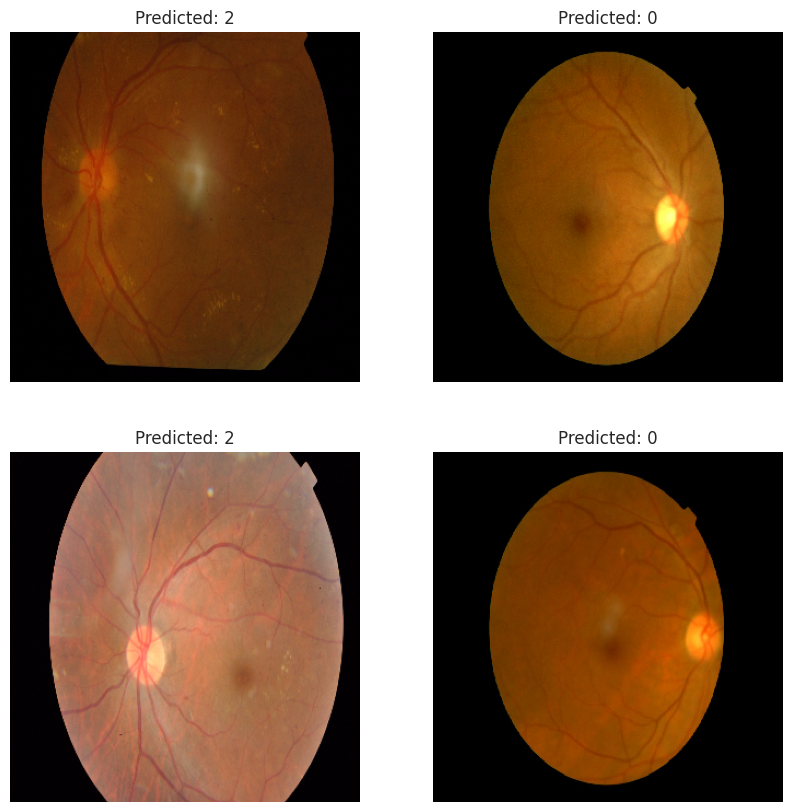

In [13]:
# prompt: show couple data images with labels

import matplotlib.pyplot as plt

# Assuming 'data' and 'predictions' are defined from the previous code
# Display the first 4 images with their predicted labels
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(4):
  ax = axes[i // 2, i % 2]
  ax.imshow(data[i])
  ax.set_title(f"Predicted: {predictions[i]}")
  ax.axis('off')
plt.show()

# Model Explainability

In [16]:
image_shape = (320, 320, 3)
predict_fn = lambda x: model.predict(x)

In [17]:
labels = [
        "No DR",
        "Mild",
        "Moderate",
        "Severe",
        "Proliferative DR"
    ]

In [18]:
def decode_predictions(preds):
    # Map each maximum index to its corresponding label
    decoded_labels = [labels[idx] for idx in preds]
    return decoded_labels

In [19]:
labels = decode_predictions(predictions)
labels

['Moderate',
 'No DR',
 'Moderate',
 'No DR',
 'No DR',
 'No DR',
 'No DR',
 'Moderate',
 'Proliferative DR',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate',
 'No DR',
 'Severe',
 'No DR',
 'Moderate',
 'Moderate',
 'No DR',
 'No DR',
 'No DR',
 'Moderate',
 'Moderate',
 'Moderate',
 'Moderate']

In [34]:
import matplotlib.pyplot as plt
from alibi.explainers import AnchorImage
import tensorflow as tf

# Constants
SEGMENTATION_FN = 'slic'  # Segmentation algorithm
SEGMENTATION_PARAMS = {'n_segments':15, 'compactness': 20, 'sigma': 0.5, 'start_label': 0}
EXPLAIN_THRESHOLD = 0.95  # Confidence threshold for the explanation
EXPLAIN_P_SAMPLE = 0.5  # Sample proportion
EXPLAIN_TAU = 0.25  # Tau parameter

# Reusable function for AnchorImage explanation
def generate_anchor_explanation(image, predict_fn, image_shape):
    """
    Generate an AnchorImage explanation for a given image and model.

    :param image: Input image to explain.
    :param predict_fn: Model prediction function.
    :param image_shape: Shape of the input image.
    :return: Explanation object.
    """
    explainer = AnchorImage(
        predictor=predict_fn,
        image_shape=image_shape,
        segmentation_fn=SEGMENTATION_FN,
        segmentation_kwargs=SEGMENTATION_PARAMS,
        images_background=None
    )
    return explainer.explain(image, threshold=EXPLAIN_THRESHOLD, p_sample=EXPLAIN_P_SAMPLE, tau=EXPLAIN_TAU)


In [57]:
def generate_html_report(patient_data, explanation_text):
    """
    Generate an HTML report for a patient's prediction explanation.

    :param patient_data: Dictionary containing patient information (e.g., name, gender, patient_id, diagnosis_date, prediction).
    :param explanation_text: Explanation text for the prediction.
    :param image_path: Path to the patient's retinal scan image.
    :return: HTML string.
    """
    diagnosis_date = patient_data['diagnosis_date'].strftime("%B %d, %Y")

    html_template = f"""
    <!doctype html>
    <html>
    <head>
        <title>Patient Report</title>
        <meta charset="UTF-8">
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; line-height: 1.6; background-color: #f9f9f9; }}
            h1, h3 {{ color: #2c3e50; }}
            .container {{ display: flex; gap: 20px; margin-bottom: 20px; }}
            .image, .details {{ flex: 1; }}
            img {{ max-width: 100%; height: auto; border: 1px solid #ccc; border-radius: 5px; }}
            .details p {{ margin: 8px 0; }}
            .footer {{ text-align: center; font-size: 0.9em; color: #7f8c8d; margin-top: 30px; }}
            .prediction {{ font-weight: bold; color: #e74c3c; }}
            .section-title {{ font-size: 1.2em; color: #34495e; margin-top: 20px; border-bottom: 2px solid #ddd; padding-bottom: 5px; }}
            .highlight {{ background-color: #f1c40f; padding: 2px 4px; border-radius: 3px; }}
        </style>
    </head>
    <body>
        <h1>Diabetic Retinopathy Diagnosis Report</h1>
        <hr>
        <div class="container">
            <div class="image">
                <h3>Patient's Retinal Scan</h3>
                <img src="/content/image.png" alt="Retinal Scan">
            </div>
            <div class="details">
                <h3>Patient Information</h3>
                <p><strong>Name:</strong> {patient_data['name']}</p>
                <p><strong>Gender:</strong> {patient_data['gender']}</p>
                <p><strong>Patient ID:</strong> {patient_data['patient_id']}</p>
                <p><strong>Diagnosis Date:</strong> {diagnosis_date}</p>
                <p><strong>Prediction:</strong> <span class="prediction">{patient_data['prediction']}</span></p>
            </div>
        </div>

        <div>
            <h3 class="section-title">Detailed Explanation of Prediction</h3>
            <p>{explanation_text}</p>
            <p>This prediction was generated using a state-of-the-art machine learning model trained on a large dataset of retinal images. The system leverages deep learning techniques to identify patterns indicative of diabetic retinopathy at various stages. </p>
            <p>Highlighted regions in the retinal scan, if any, represent areas of particular interest where signs of the condition may be present.</p>
            <div class="container">
                <div class="image">
                    <h3>Anchor</h3>
                    <img src="/content/anchor.png" alt="Retinal Scan Anchor">
                </div>
                <div class="image">
                    <h3>Segments</h3>
                    <img src="/content/segments.png" alt="Retinal Scan Segments">
                </div>
            </div>
        </div>

        <div>
            <h3 class="section-title">Next Steps for the Patient</h3>
            <p>1. <strong>Consult a Specialist:</strong> It is strongly recommended that you schedule an appointment with an ophthalmologist for further examination and confirmation of the diagnosis.</p>
            <p>2. <strong>Follow a Healthy Lifestyle:</strong> Managing blood sugar levels, maintaining a balanced diet, and regular exercise are critical to preventing the progression of diabetic retinopathy.</p>
            <p>3. <strong>Regular Screenings:</strong> Patients with diabetes should undergo annual eye exams to monitor their condition and detect any changes early.</p>
        </div>

        <div>
            <h3 class="section-title">About Diabetic Retinopathy</h3>
            <p>Diabetic retinopathy is a common complication of diabetes that affects the blood vessels in the retina. If left untreated, it can lead to vision loss. Early detection and treatment are crucial to managing this condition effectively.</p>
            <p>Stages of diabetic retinopathy include:</p>
            <ul>
                <li><strong>Mild Non-Proliferative Retinopathy:</strong> Small areas of swelling in the retina's blood vessels.</li>
                <li><strong>Moderate Non-Proliferative Retinopathy:</strong> Progression of swelling, causing blockages in some blood vessels.</li>
                <li><strong>Severe Non-Proliferative Retinopathy:</strong> More blood vessels are blocked, depriving the retina of blood supply.</li>
                <li><strong>Proliferative Retinopathy:</strong> Advanced stage with the growth of new, abnormal blood vessels that can bleed and cause serious vision problems.</li>
            </ul>
        </div>

    </body>
    </html>
    """
    return html_template


In [47]:
def visualize_explanation(image, explanation, title_prefix=""):
    """
    Visualize the patient's retinal image and explanation overlay.

    :param image: Patient's retinal image as a NumPy array.
    :param explanation: Explanation object with a mask or heatmap.
    :param title_prefix: Prefix for the plot title.
    """
    # Plot and save the original retinal image
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.title(f"{title_prefix}Retinal Image")
    plt.axis('off')
    plt.savefig("image.png")
    plt.show()

    # Plot and save the explanation anchor
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.imshow(explanation.anchor, alpha=0.5)
    plt.title(f"{title_prefix}Explanation Anchor")
    plt.axis('off')
    plt.savefig("anchor.png")
    plt.show()

    # Plot and save the explanation segments
    plt.figure(figsize=(8, 8))
    plt.imshow(image, cmap='gray')
    plt.imshow(explanation.segments, alpha=0.5)
    plt.title(f"{title_prefix}Explanation Segments")
    plt.axis('off')
    plt.savefig("segments.png")
    plt.show()


In [54]:
def get_text_explanation(prediction_label):
    """
    Generate a textual explanation based on the prediction label.

    :param prediction_label: Predicted condition label.
    :return: Explanation string.
    """
    explanations = {
        "No DR": "No signs of diabetic retinopathy detected.",
        "Mild": "Mild signs of diabetic retinopathy detected. Regular monitoring is advised.",
        "Moderate": "Moderate diabetic retinopathy detected. Consult your healthcare provider.",
        "Severe": "Severe diabetic retinopathy detected. Immediate medical attention is recommended.",
        "Proliferative DR": "Proliferative diabetic retinopathy detected. Immediate treatment is required."
    }
    return explanations.get(prediction_label, "Unknown condition.")


In [49]:
from datetime import datetime

In [60]:
def process_patients(data, predictions, predict_fn, image_shape):
    """
    Generate explanations and HTML reports for multiple patients.

    :param data: Array of input images.
    :param predictions: Array of model predictions.
    :param predict_fn: Model prediction function.
    :param image_shape: Shape of input images.
    """
    for i, image in enumerate(data):
        # Generate explanation
        prediction_label = labels[predictions[i]]
        explanation_text = get_text_explanation(prediction_label)
        explanation = generate_anchor_explanation(image, predict_fn, image_shape)

        # Visualize explanation
        visualize_explanation(image, explanation, title_prefix=f"Patient {i+2}: ")

        # Patient details
        patient_data = {
            "name": f"Patient {i+2}",
            "gender": "Male" if i % 2 == 0 else "Female",
            "patient_id": f"P-{1000 + i + 1}",
            "diagnosis_date": datetime.now(),
            "prediction": prediction_label
        }

        # Generate HTML report
        html_content = generate_html_report(patient_data, explanation_text)

        # Save HTML report to file
        html_file_path = f"patient_{i+2}_report.html"
        with open(html_file_path, "w") as html_file:
            html_file.write(html_content)


4/4 [==============================] - 44s 10s/step


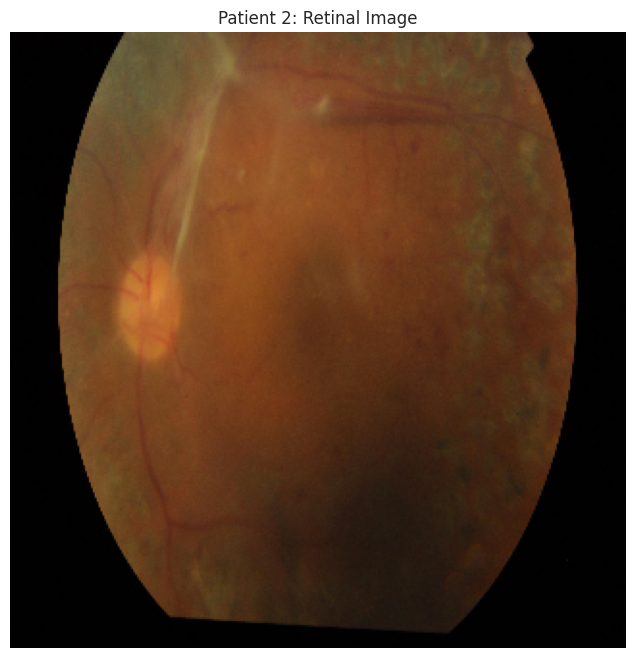

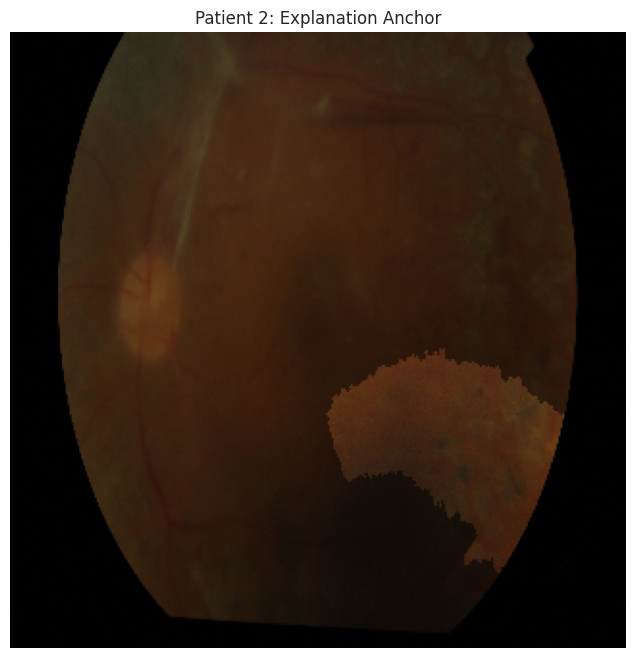

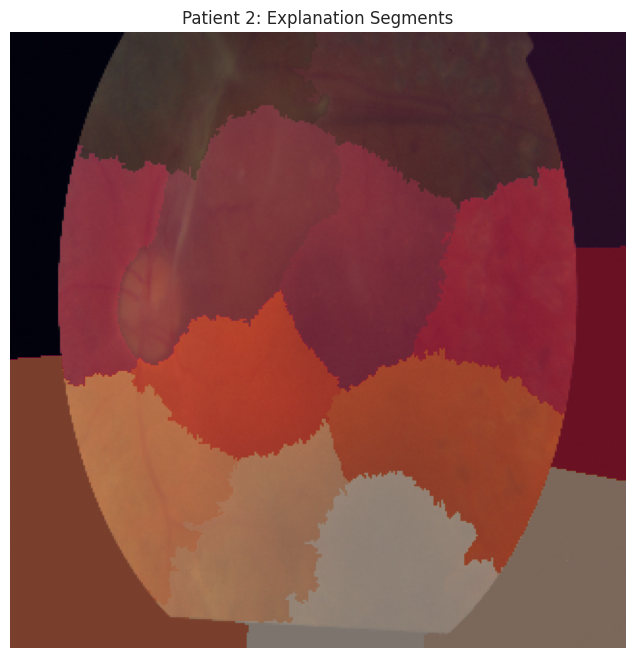

In [61]:
# Example patient data and function calls
test_data = [data[8]]
test_predictions = [predictions[8]]
process_patients(test_data, test_predictions, predict_fn, image_shape)
